<a href="https://colab.research.google.com/github/Alicia-a19/TADM-MUMADE/blob/main/TADM2022_S04_Razonamiento_Aproximado_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAZONAMIENTO APROXIMADO - NAÏVE BAYES

Estudiante: Alicia Megía Ortega

Enlaces para entender la base de datos y las relaciones entre las tablas existentes en esta.

[Guia al Conjunto de Datos](https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm)

[Extracto del Diseño](https://dbdesigner.page.link/7iRemaQAUMsbFb2o7)


Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables nos den la probabilidad o el rating de darle un préstamo a un cliente

## Carga de Datos

In [ ]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:00<00:00, 134MB/s]


### Carga extensión sql

1. Cargamos la extensión sql

In [ ]:
%load_ext sql

2. Nos conectamos con la base de datos

In [ ]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

¿Cuántos préstamos hay por cada estado (status)?


Aliases are used to give a table, or a column in a table, a temporary name.  
Aliases are often used to make column names more readable.  
An alias only exists for the duration of that query (consulta).  
An alias is created with the AS keyword.  

In [ ]:
%%sql
SELECT status, count(*) as Total
FROM loan
GROUP BY status
ORDER BY Total DESC 

 * sqlite:///data_berka.db
Done.


status,Total
C,403
A,203
D,45
B,31


## CONJUNTO 1

### Extracción de los datos de entrenamiento (train)

Para posterior construcción de dataframe de datos de entrenamiento.

Vamos a empezar obteniendo los datos de los préstamos ya finalizados. Van a ser nuestros datos de entrenamiento. Por lo que seleccionaremos únicamente aquellos préstamos en `status 'A' o 'B'`. 

Con una sentencia CASE vamos a poner los prestamos finalizados bien a 1 y los que no finalizaron bien a 0. 

Sintaxis de uso de [INNER JOIN](https://www.sqlitetutorial.net/sqlite-inner-join/) para establecer joins entre tablas

The CASE statement goes through conditions and returns a value when the first condition is met (like an if-then-else statement). So, once a condition is true, it will stop reading and return the result. If no conditions are true, it returns the value in the ELSE clause.

If there is no ELSE part and no conditions are true, it returns NULL.

'<<' para guardar en una nueva variable (asignación)

* The SUBSTR() function extracts a substring from a string (starting at any position).
* Syntax: SUBSTR(string, start, length) or SUBSTR(string FROM start FOR length).  

substr(l.date,0,3) para extraer los primeros 2 dígitos de la fecha

[SQLite CASE](https://www.sqlitetutorial.net/sqlite-case/)

The simple CASE expression compares the case_expression to the expression appears in the first WHEN clause, when_expression_1, for equality.

If the case_expression equals when_expression_1, the simple CASE returns the expression in the corresponding THEN clause, which is the result_1.

Otherwise, the simple CASE expression compares the case_expression with the expression in the next WHEN clause.

In case no case_expression matches the when_expression, the CASE expression returns the result_else in the ELSE clause. If you omit the ELSE clause, the CASE expression returns NULL.

The simple CASE expression uses short-circuit evaluation. In other words, it returns the result and stop evaluating other conditions as soon as it finds a match.

CASE case_expression  
     WHEN when_expression_1 THEN result_1  
     WHEN when_expression_2 THEN result_2  
     ...  
     [ ELSE result_else ]   
END

In [ ]:
%%sql
SELECT SUBSTR(l.date, 0, 3) AS year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
FROM LOAN AS l, ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
WHERE l.account_id = a.account_id
  AND l.status IN ('A', 'B')
LIMIT 10

In [ ]:
%%sql 
loans_train << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d ON a.district_id = d.A1 
  WHERE l.account_id = a.account_id 
    AND l.status IN ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train


3. Obtenemos el DataFrame

Conversión de los datos en un dataframe  
Transformación en DataFrame de Pandas

In [ ]:
df_train = loans_train.DataFrame()
df_train.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


Shape of an Array

The shape of an array is the number of elements in each dimension.  
Las dimensiones del DataFrame (rows,columns) <> (observaciones, variables)

In [ ]:
df_train.shape

(234, 7)

### Extracción de los datos de validación (test)

Para la parte de *test* lo que vamos a extraer de la Base de Datos son los préstamos que están en ejecución (`status in ("C", "D")`) con los mismos campos que en la consulta anterior.

In [ ]:
%%sql loans_test << SELECT SUBSTR(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d ON a.district_id = d.A1 
  WHERE l.account_id = a.account_id 
    AND l.status IN ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test


Se transforma en un Data.Frame de Pandas

In [ ]:
df_test = loans_test.DataFrame()
df_test.head()

,year,amount,duration,payments,A11,A13,label
0,94,253200,60,4220,9893,4.72,1
1,94,300660,60,5011,9317,7.07,1
2,94,167100,60,2785,8544,1.86,1
3,94,149340,60,2489,8254,3.76,1
4,94,89040,60,1484,8909,5.56,1


In [ ]:
df_test.shape

(448, 7)

### División de los conjuntos de datos

4. División de los datos en entrenamiento y test

`features` es una variable de tipo lista que me almacena los nombres de las características que me sirven como **entrada**

In [ ]:
features = ["year", "amount", "duration", "payments","A11", "A13"]

* train (creación del modelo) : datos de préstamos ya finalizados
* test (evaluación del modelo): datos de préstamos en ejecución

In [ ]:
X_train = df_train[features]
y_train = df_train["label"]

X_test = df_test[features]
y_test = df_test["label"]


### Estandarización de los datos (normalización)

5. Normalizarlos puede ser una buena medida para obtener mejores resultados.
Para ello vamos a utilizar el [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

El centrado y el escalado se realizan de forma independiente en cada característica, calculando las estadísticas pertinentes en las muestras del **conjunto de entrenamiento**. La media y la desviación estándar se almacenan para utilizarlas en datos posteriores mediante una **transformación**.

Mas información sobre normalización en el siguiente [enlace](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)


.fit realiza el cálculo de los parámetros de escalado (no se ha de realizar el fit a los datos de test)  
.transform transforma los datos una vez calculados los parámetros

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train) 
# transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Aplicación de Naïve-Bayes

Aplicamos un modelo [NaiveBayes](https://scikit-learn.org/stable/modules/naive_bayes.html?highlight=naive+bayes) para construir un clasificador de préstamos

In [ ]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test.shape[0], (y_test != y_pred).sum()))

Número de préstamos clasificados erroneamente 448 de un total de  123


Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados [`classification report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.20      0.60      0.31        45
           1       0.94      0.74      0.83       403

    accuracy                           0.73       448
   macro avg       0.57      0.67      0.57       448
weighted avg       0.87      0.73      0.78       448



precision  
recall (sensibilidad)  
f1-score ("media armónica" entre precisión y sensibilidad) 

Y la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

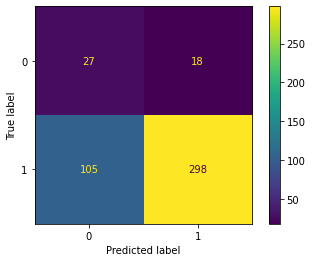

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

Diagonal principal los valores acertados por el clasificador  
Parte inferior valores predichos  
Parte izquierda valores reales  
Fuera de la diagonal principal son los fallos  
La tabla anterior los parámetros podrían ser calculados a partir de la matriz de confusión

Clasificador no está balanceado

## CONJUNTO 2

### Extracción de otro conjunto de datos para subconjunto de entrenamiento

**Ejercicio**: Añadir la edad del cliente propietario de la cuenta del prestamo y algún campo de datos demográficos adicionales


In [ ]:
%%sql
SELECT *
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id -- join account/disposition
  AND dp.client_id = c.client_id -- join disposition/client
LIMIT 10

In [ ]:
%%sql
SELECT SUBSTR(l.date, 0, 3) AS year, amount, duration, payments, A8, A11, A13, A16, SUBSTR(birth_number, 0, 3) as age,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id -- join account/disposition
  AND dp.client_id = c.client_id -- join disposition/client
  AND l.status IN ("A", "B")
LIMIT 10

In [ ]:
%%sql
loans_train2 << SELECT SUBSTR(l.date, 0, 3) AS year, amount, duration, payments, A8, A11, A13, A16, SUBSTR(birth_number, 0, 3) as age,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id
  AND dp.client_id = c.client_id
  AND l.status IN ("A", "B")

Conversión de los datos en tabla (DataFrame) de pandas

In [ ]:
df_train2 = loans_train2.DataFrame()
df_train2.head()

,year,amount,duration,payments,A8,A11,A13,A16,age,label
0,94,80952,24,3373,1,12541,0.43,99107,45,1
1,94,80952,24,3373,1,12541,0.43,99107,40,1
2,96,30276,12,2523,1,9104,2.07,2354,39,0
3,97,30276,12,2523,2,9893,4.72,5887,62,1
4,96,165960,24,6915,1,8427,1.54,1913,44,1


Dimensiones de la tabla

In [ ]:
df_train2.shape

### Extracción de otro conjunto de datos para subconjunto de validación

In [ ]:
%%sql
SELECT SUBSTR(l.date, 0, 3) AS year, amount, duration, payments, A8, A11, A13, A16, SUBSTR(birth_number, 0, 3) as age,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id
  AND dp.client_id = c.client_id
  AND l.status IN ("C", "D")
LIMIT 10

In [ ]:
%%sql
loans_test2 << SELECT SUBSTR(l.date, 0, 3) AS year, amount, duration, payments, A8, A11, A13, A16, SUBSTR(birth_number, 0, 3) as age,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id
  AND dp.client_id = c.client_id
  AND l.status IN ("C", "D")

Conversión de los datos en una tabla (DataFrame) de pandas

In [ ]:
df_test2 = loans_test2.DataFrame()
df_test2.head()

Dimensión de la tabla

In [ ]:
df_test2.shape

(538, 10)

### Otro/s clasificadores de préstamos

**Ejercicios**

Plantear el clasificador de préstamos añadiendo datos de otras tablas de la base de datos, u otros campos de las mismas tablas (edad del cliente, etc).

Otras transformaciones: [Discretización](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization) y utilización de otros clasificadores NB

### División de los datos en los subconjuntos

In [ ]:
features2 = ["year", "amount", "duration", "payments", "A8", "A11", "A13", "A16", "age"]

In [ ]:
X_train2 = df_train2[features2]
y_train2 = df_train2["label"]

X_test2 = df_test2[features2]
y_test2 = df_test2["label"]


### Normalización de los datos

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train2) 
# transformación
X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)

### Naïve-Bayes

#### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train2, y_train2)
y_pred2 = clf.predict(X_test2)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test2.shape[0], (y_test2 != y_pred2).sum()))


Número de préstamos clasificados erroneamente 538 de un total de  160


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred2, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.16      0.60      0.25        45
           1       0.95      0.71      0.81       493

    accuracy                           0.70       538
   macro avg       0.56      0.66      0.53       538
weighted avg       0.89      0.70      0.77       538



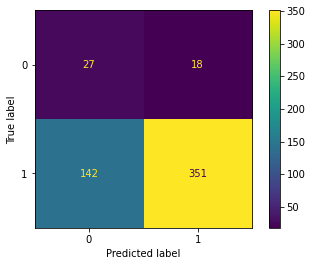

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test2, y_pred2, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

#### Parámetros de la matriz de confusión

Exactitutd  
correct predictions / total predictions   
 
Esto es simplemente igual a la proporción de predicciones que el modelo clasificó correctamente.

In [ ]:
Accuracy = (27+351)/(142+351+18+27)
print(Accuracy)

0.7026022304832714


Precision   
True Positive / True positive + False positive  

La precisión también se conoce como valor predictivo positivo y es la proporción de instancias relevantes entre las instancias recuperadas. En otras palabras, responde a la pregunta "¿Qué proporción de identificaciones positivas fue realmente correcta?"

In [ ]:
Precision = (351)/(351+18)
print(Precision)

0.9512195121951219


Sensibilidad  
True positive / True Positive + False Negative
  
La sensibilidad, tasa de aciertos o tasa positiva real (TPR), es la proporción de la cantidad total de instancias pertinentes que se recuperaron realmente. Responde a la pregunta "¿Qué proporción de positivos reales se identificó correctamente?"

In [ ]:
Recall = (351)/(351+142)
print(Recall)

0.7119675456389453


Especificidad  
True negative / True negative + False positive  

La especificidad, también conocida como tasa negativa real (TNR), mide la proporción de negativos reales que se identifican correctamente como tales. Es lo opuesto a la sensibilidad.

In [ ]:
Specifity = (27)/(27+142)
print(Specifity)

0.15976331360946747


Puntuación F1  

2·(precision·recall)/precision + recall  

2TruePositive/2TruePositive+FalsePositive+FalseNegative


El puntaje F1 es una medida de la precisión de una prueba, es la media armónica de precisión y recuperación. Puede tener una puntuación máxima de 1 (precisión y recuerdo perfectos) y una mínima de 0. En general, es una medida de la precisión y robustez de su modelo.

In [ ]:
F1score = (2*351)/(2*351+142+18)
print(F1score)

0.814385150812065


#### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
clf2 = bnb.fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test2.shape[0], (y_test2 != y_pred2).sum()))

Número de préstamos clasificados erroneamente 538 de un total de  45


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred2, labels=clf2.classes_))

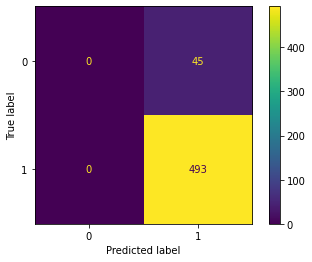

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test2, y_pred2, labels= clf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf2.classes_)
disp.plot()

### Discretización de los *datos*

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

dis = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='uniform')
# Cálculo de la discretización de los datos
dis.fit(X_train2) 
# transformación
X_train2b = dis.transform(X_train2)
X_test2b = dis.transform(X_test2)

### Naïve-Bayes

#### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train2b, y_train2)
y_pred2b = clf.predict(X_test2b)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test2b.shape[0], (y_test2 != y_pred2b).sum()))


Número de préstamos clasificados erroneamente 538 de un total de  172


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred2b, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.15      0.62      0.25        45
           1       0.95      0.69      0.80       493

    accuracy                           0.68       538
   macro avg       0.55      0.65      0.52       538
weighted avg       0.89      0.68      0.75       538



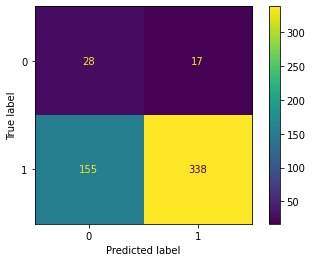

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test2, y_pred2b, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

#### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
clf2 = bnb.fit(X_train2b, y_train2)
y_pred2b = clf2.predict(X_test2b)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test2b.shape[0], (y_test2 != y_pred2b).sum()))

Número de préstamos clasificados erroneamente 538 de un total de  335


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred2b, labels=clf2.classes_))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.92      1.00      0.96       493

    accuracy                           0.92       538
   macro avg       0.46      0.50      0.48       538
weighted avg       0.84      0.92      0.88       538



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


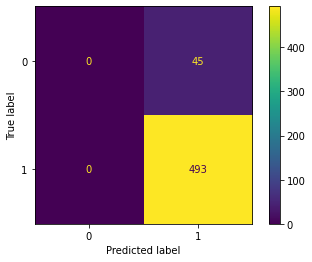

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test2, y_pred2b, labels= clf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf2.classes_)
disp.plot()

#### ComplementNB

In [ ]:
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB()
clf3 = cnb.fit(X_train2b, y_train2)
y_pred2b = clf3.predict(X_test2b)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test2b.shape[0], (y_test2 != y_pred2b).sum()))

Número de préstamos clasificados erroneamente 538 de un total de  335


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred2b, labels=clf3.classes_))

              precision    recall  f1-score   support

           0       0.10      0.80      0.18        45
           1       0.95      0.34      0.50       493

    accuracy                           0.38       538
   macro avg       0.52      0.57      0.34       538
weighted avg       0.88      0.38      0.47       538



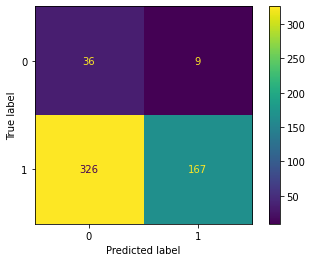

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test2, y_pred2b, labels= clf3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf3.classes_)
disp.plot()

#### MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
clf4 = mnb.fit(X_train2b, y_train2)
y_pred2b = clf4.predict(X_test2b)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test2b.shape[0], (y_test2 != y_pred2b).sum()))

Número de préstamos clasificados erroneamente 538 de un total de  211


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred2b, labels=clf4.classes_))

              precision    recall  f1-score   support

           0       0.12      0.58      0.20        45
           1       0.94      0.61      0.74       493

    accuracy                           0.61       538
   macro avg       0.53      0.59      0.47       538
weighted avg       0.87      0.61      0.70       538



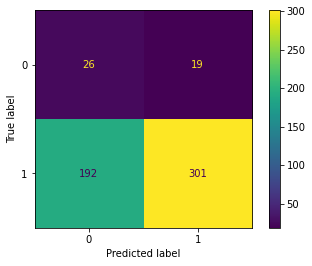

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test2, y_pred2b, labels= clf4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf4.classes_)
disp.plot()

## CONJUNTO 3

### Nueva extracción de datos (diferentes) para subconjunto de entrenamiento

In [ ]:
%%sql
SELECT SUBSTR(l.date, 0, 3) AS year, l.amount, duration, payments, A11, A13,
  SUBSTR(birth_number, 0, 3) as age, po.amount AS DebtAmount,
  CASE cc.type WHEN 'junior' THEN 1
               WHEN 'classic' THEN 2
               WHEN 'gold' THEN 3
  END CardType,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
  INNER JOIN CREDIT_CARD AS cc ON cc.disp_id = dp.disp_id
  INNER JOIN PERMANENT_ORDER AS po ON a.account_id = po.account_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id
  AND dp.client_id = c.client_id
  AND cc.disp_id = dp.disp_id
  AND a.account_id = po.account_id
  AND l.status IN ("A", "B")
LIMIT 10

In [ ]:
%%sql
loans_train3 << SELECT SUBSTR(l.date, 0, 3) AS year, l.amount, duration, payments, A11, A13,
  SUBSTR(birth_number, 0, 3) as age, po.amount AS DebtAmount,
  CASE cc.type WHEN 'junior' THEN 1
               WHEN 'classic' THEN 2
               WHEN 'gold' THEN 3
  END CardType,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
  INNER JOIN CREDIT_CARD AS cc ON cc.disp_id = dp.disp_id
  INNER JOIN PERMANENT_ORDER AS po ON a.account_id = po.account_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id
  AND dp.client_id = c.client_id
  AND cc.disp_id = dp.disp_id
  AND a.account_id = po.account_id
  AND l.status IN ("A", "B")

In [ ]:
df_train3 = loans_train3.DataFrame()
df_train3.head()

In [ ]:
df_train3.shape

(140, 10)

### Nueva extracción de datos (diferentes) para subconjunto de validación

In [ ]:
%%sql
SELECT SUBSTR(l.date, 0, 3) AS year, l.amount, duration, payments, A11, A13,
  SUBSTR(birth_number, 0, 3) as age, po.amount AS DebtAmount,
  CASE cc.type WHEN 'junior' THEN 1
               WHEN 'classic' THEN 2
               WHEN 'gold' THEN 3
  END CardType,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
  INNER JOIN CREDIT_CARD AS cc ON cc.disp_id = dp.disp_id
  INNER JOIN PERMANENT_ORDER AS po ON a.account_id = po.account_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id
  AND dp.client_id = c.client_id
  AND cc.disp_id = dp.disp_id
  AND a.account_id = po.account_id
  AND l.status IN ("C", "D")
LIMIT 10

In [ ]:
%%sql
loans_test3 << SELECT SUBSTR(l.date, 0, 3) AS year, l.amount, duration, payments, A11, A13,
  SUBSTR(birth_number, 0, 3) as age, po.amount AS DebtAmount,
  CASE cc.type WHEN 'junior' THEN 1
               WHEN 'classic' THEN 2
               WHEN 'gold' THEN 3
  END CardType,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
  INNER JOIN CREDIT_CARD AS cc ON cc.disp_id = dp.disp_id
  INNER JOIN PERMANENT_ORDER AS po ON a.account_id = po.account_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id
  AND dp.client_id = c.client_id
  AND cc.disp_id = dp.disp_id
  AND a.account_id = po.account_id
  AND l.status IN ("C", "D")

In [ ]:
df_test3 = loans_test3.DataFrame()
df_test3.head()

In [ ]:
df_test3.shape

(214, 10)

### División de los datos en los subconjuntos

In [ ]:
features3 = ["year", "amount", "duration", "payments", "A11", "A13", "age", "DebtAmount", "CardType"]

In [ ]:
X_train3 = df_train3[features3]
y_train3 = df_train3["label"]

X_test3 = df_test3[features3]
y_test3 = df_test3["label"]


### Normalización de los datos

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train3) 
# transformación
X_train3 = scaler.transform(X_train3)
X_test3 = scaler.transform(X_test3)

### Naïve-Bayes

#### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train3, y_train3)
y_pred3 = clf.predict(X_test3)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test3.shape[0], (y_test3 != y_pred3).sum()))


Número de préstamos clasificados erroneamente 214 de un total de  6


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test3, y_pred3, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.99      0.99      0.99       211

    accuracy                           0.97       214
   macro avg       0.49      0.49      0.49       214
weighted avg       0.97      0.97      0.97       214



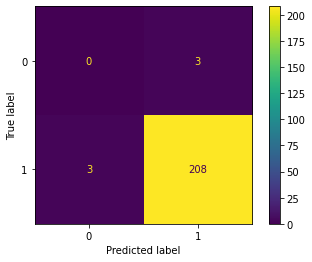

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test3, y_pred3, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

#### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
clf2 = bnb.fit(X_train3, y_train3)
y_pred2 = clf2.predict(X_test3)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test3.shape[0], (y_test3 != y_pred3).sum()))

Número de préstamos clasificados erroneamente 214 de un total de  6


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test3, y_pred3, labels=clf2.classes_))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.99      0.99      0.99       211

    accuracy                           0.97       214
   macro avg       0.49      0.49      0.49       214
weighted avg       0.97      0.97      0.97       214



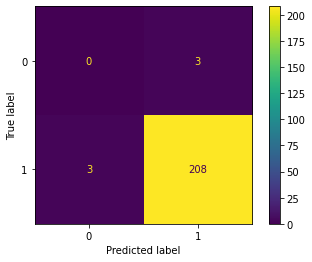

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test3, y_pred3, labels= clf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf2.classes_)
disp.plot()

### Discretización de los *datos*

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

dis2 = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='uniform')
# Cálculo de la discretización de los datos
dis2.fit(X_train3) 
# transformación
X_train3b = dis.transform(X_train3)
X_test3b = dis.transform(X_test3)

### Naïve-Bayes

#### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train3b, y_train3)
y_pred3b = clf.predict(X_test3b)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test3b.shape[0], (y_test3 != y_pred3b).sum()))


Número de préstamos clasificados erroneamente 214 de un total de  6


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test3, y_pred3b, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.99      0.99      0.99       211

    accuracy                           0.97       214
   macro avg       0.49      0.49      0.49       214
weighted avg       0.97      0.97      0.97       214



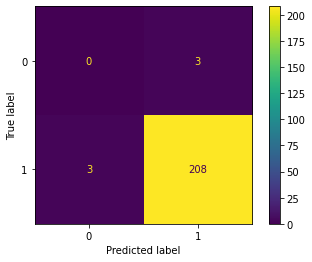

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test3, y_pred3b, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

#### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
clf2 = bnb.fit(X_train3b, y_train3)
y_pred3b = clf2.predict(X_test3b)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test3b.shape[0], (y_test3 != y_pred3b).sum()))

Número de préstamos clasificados erroneamente 214 de un total de  5


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test3, y_pred3b, labels=clf2.classes_))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.99      0.99      0.99       211

    accuracy                           0.98       214
   macro avg       0.49      0.50      0.49       214
weighted avg       0.97      0.98      0.97       214



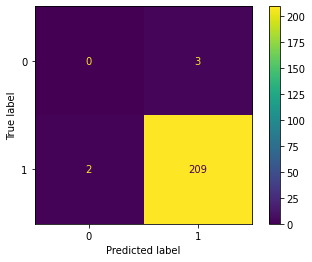

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test3, y_pred3b, labels= clf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf2.classes_)
disp.plot()

#### ComplementNB

In [ ]:
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB()
clf3 = cnb.fit(X_train3b, y_train3)
y_pred3b = clf3.predict(X_test3b)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test3b.shape[0], (y_test3 != y_pred3b).sum()))

Número de préstamos clasificados erroneamente 214 de un total de  30


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test3, y_pred3b, labels=clf3.classes_))

              precision    recall  f1-score   support

           0       0.10      0.80      0.18        45
           1       0.95      0.34      0.50       493

    accuracy                           0.38       538
   macro avg       0.52      0.57      0.34       538
weighted avg       0.88      0.38      0.47       538



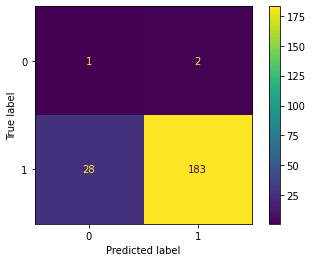

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test3, y_pred3b, labels= clf3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf3.classes_)
disp.plot()

#### MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
clf4 = mnb.fit(X_train3b, y_train3)
y_pred3b = clf4.predict(X_test3b)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test3b.shape[0], (y_test3 != y_pred3b).sum()))

Número de préstamos clasificados erroneamente 214 de un total de  22


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test3, y_pred3b, labels=clf4.classes_))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.98      0.91      0.95       211

    accuracy                           0.90       214
   macro avg       0.49      0.45      0.47       214
weighted avg       0.97      0.90      0.93       214



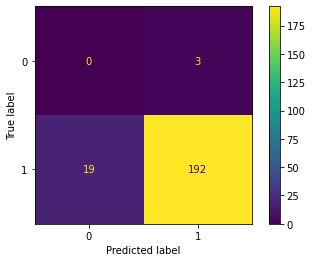

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test3, y_pred3b, labels= clf4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf4.classes_)
disp.plot()

# UNSUCCESSFUL ATTEMPTS

### CONJUNTO 4

### Extracción de los subconjuntos de datos sin factorizar previamente la variable credit card type

In [ ]:
%%sql
loans_train4 << SELECT SUBSTR(l.date, 0, 3) AS year, l.amount, duration, payments, A11, A13,
  SUBSTR(birth_number, 0, 3) as age, po.amount AS DebtAmount, cc.type AS CardType,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
  INNER JOIN CREDIT_CARD AS cc ON cc.disp_id = dp.disp_id
  INNER JOIN PERMANENT_ORDER AS po ON a.account_id = po.account_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id
  AND dp.client_id = c.client_id
  AND cc.disp_id = dp.disp_id
  AND a.account_id = po.account_id
  AND l.status IN ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train4


In [ ]:
df_train4 = loans_train4.DataFrame()
df_train4.head()

,year,amount,duration,payments,A11,A13,age,DebtAmount,CardType,label
0,94,51696,24,2154,10673,5.44,68,2153.8,classic,1
1,94,82896,12,6908,8441,4.48,72,41.0,classic,1
2,94,82896,12,6908,8441,4.48,72,119.0,classic,1
3,94,82896,12,6908,8441,4.48,72,6907.5,classic,1
4,94,82896,12,6908,8441,4.48,72,9716.0,classic,1


In [ ]:
df_train4.shape

(140, 10)

In [ ]:
%%sql
loans_test4 << SELECT SUBSTR(l.date, 0, 3) AS year, l.amount, duration, payments, A11, A13,
  SUBSTR(birth_number, 0, 3) as age, po.amount AS DebtAmount,
  CASE cc.type WHEN 'junior' THEN 1
               WHEN 'classic' THEN 2
               WHEN 'gold' THEN 3
  END CardType,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
FROM LOAN AS l,
  ACCOUNT AS a INNER JOIN DISTRICT AS d ON a.district_id = d.A1
  INNER JOIN DISPOSITION AS dp ON a.account_id = dp.account_id
  INNER JOIN CLIENT AS c ON dp.client_id = c.client_id
  INNER JOIN CREDIT_CARD AS cc ON cc.disp_id = dp.disp_id
  INNER JOIN PERMANENT_ORDER AS po ON a.account_id = po.account_id
WHERE l.account_id = a.account_id
  AND a.account_id = dp.account_id
  AND dp.client_id = c.client_id
  AND cc.disp_id = dp.disp_id
  AND a.account_id = po.account_id
  AND l.status IN ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test4


In [ ]:
df_test4 = loans_test4.DataFrame()
df_test4.head()

In [ ]:
df_test4.shape

In [ ]:
features4 = ["year", "amount", "duration", "payments", "A11", "A13", "age", "DebtAmount", "CardType"]

In [ ]:
X_train4 = df_train4[features3]
y_train4 = df_train4["label"]

X_test4 = df_test4[features3]
y_test4 = df_test4["label"]


### Preprocesamiento de datasets automatizado

In [ ]:
from sklearn.compose import ColumnTransformer
num_attrs = ["year", "amount", "duration", "payments", "A11", "A13", "DebtAmount"]
text_attrs = ["CardType"]

pipeline = ColumnTransformer([
                              ("numeric", StandardScaler(), num_attrs),
                              ("text", OrdinalEncoder(), text_attrs)
])
preprocessed_X_train4 = pipeline.fit_transform(X_train4)

### Ordinal Encoding (Attempt)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Se crea el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[["junior", "classic", "gold"]])

# Ajustamos el codificador con la variable CardType y la transformamos
encoder.fit(X_train4[["CardType"]])
X_train4["CardType-encoded"] = encoder.transform(X_train4[["CardType"]])

In [ ]:
X_train4[["CardType", "CardType-encoded"]].head(10)

## Attempt (Standard Scale)   

### MultinomalNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
clf3 = mnb.fit(X_train3, y_train3)
y_pred2 = clf3.predict(X_test3)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test3.shape[0], (y_test3 != y_pred3).sum()))

### ComplementNB

In [ ]:
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB()
clf4 = cnb.fit(X_train3, y_train3)
y_pred2 = clf4.predict(X_test3)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test3.shape[0], (y_test3 != y_pred3).sum()))